In [323]:
# Example reading the SQL database from here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [324]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv',sep=";")
df_raw.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [325]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [326]:
# No hay valores faltantes

## EDA

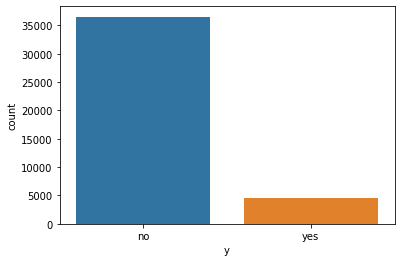

In [327]:
sns.countplot(x=df_raw['y'], data=df_raw.drop(columns=['y'],axis=1))
plt.show()

#Podemos ver que los datos de severamente desbalanceados con una inclinacion al valor 'no' en la columna target 'y'

In [328]:
X = df_raw.drop(columns=["y"],axis=1)
y = df_raw["y"]

In [329]:
numeric_features = X.select_dtypes(['float','int'])
categorical_features = X.select_dtypes(['object'])

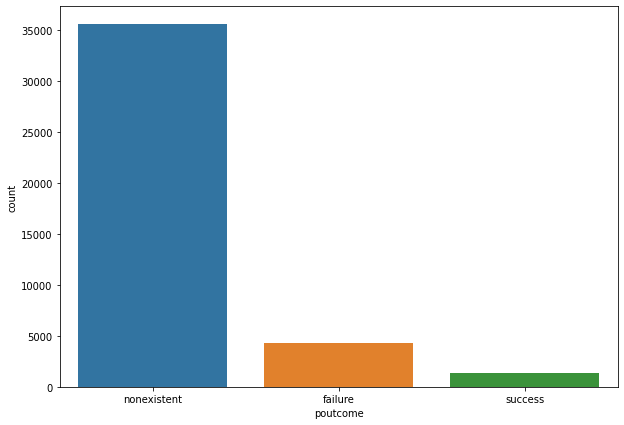

In [330]:
# Poutcome

fig = plt.figure(figsize=(10,7))
plot=sns.countplot(x='poutcome',data=X)
plt.show()

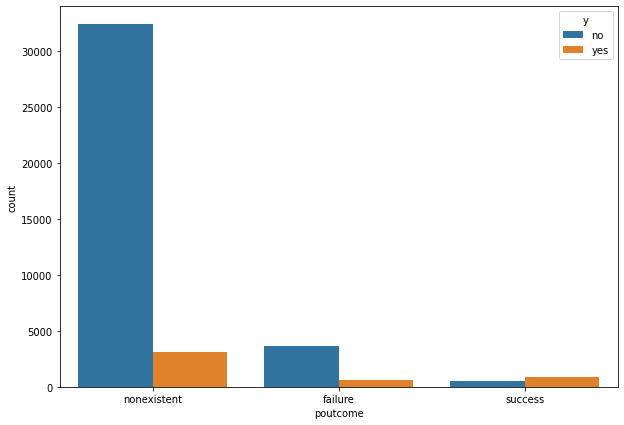

In [331]:
fig = plt.figure(figsize=(10,7))
plot=sns.countplot(x='poutcome',data=X,hue=y)
plt.show()

In [332]:
# Hay mucha gente que anteriormente nunca acepto o rechazo la propuesta, pero algunos de ellos si actualmente deicidieron hacer un term deposit

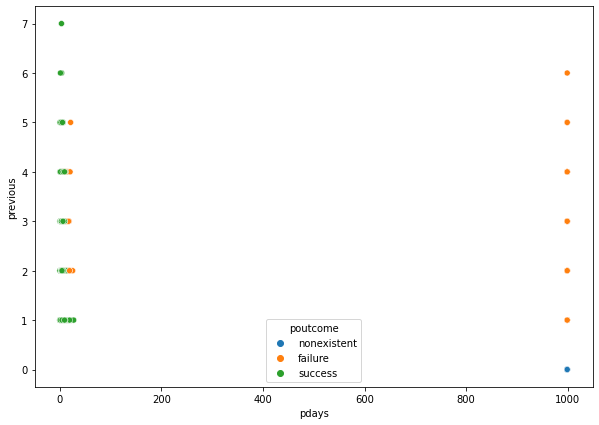

In [333]:
# Pdays vs previous

plt.figure(figsize=(10,7))
sns.scatterplot(x=X['pdays'], y=X['previous'], hue = X['poutcome'])
plt.show()

La variable pdays genera confusion con poutcome, ya que los puntos naranjas de la derecha nos indican que fueron fracasos contactados antes (por previous) y a su vez serian fracasos nunca contactados, por lo que se va a dropear la columna pdays y usar solo como criterio previous si el cliente fue contactado antes

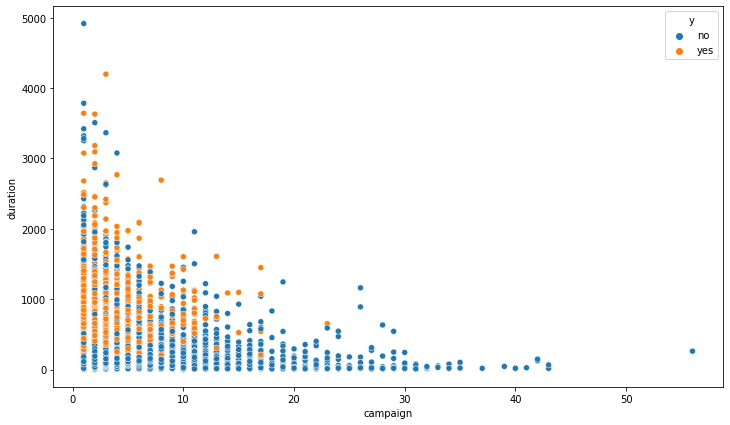

In [334]:
# Campaign vs duration

plt.figure(figsize=(12,7))
sns.scatterplot(x= X['campaign'], y= X['duration'], hue = y)
plt.show()

A menor cantidad de contactos y mayor duracion de llamada, mas probable de tener un outcome positivo

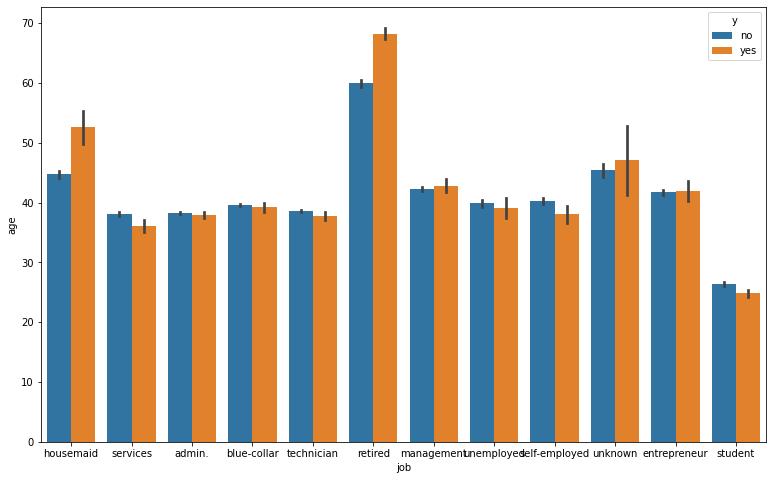

In [335]:
# Contraste entre job, age y el outcome

plt.figure(figsize=(13,8)) 
sns.barplot(x= X['job'], y= X['age'], hue= y)
plt.show()

Empleadas domesticas de aporximadamente 50 años y jubilados de aproximadamente 65 años son los grupos con mayor indice de aceptar la propuesta

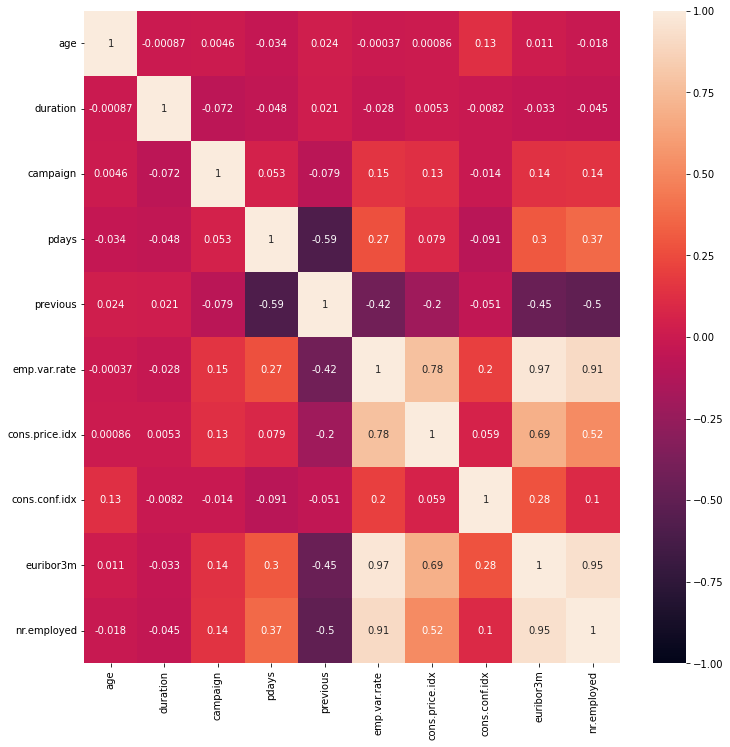

In [336]:
#Chequeamos los features mas relacionados entre si

plt.figure(figsize=(12,12))
sns.heatmap(df_raw.corr(),annot=True,vmin=-1,vmax=1)
plt.show()

Pdays se va a dropear, asi que se elimina esa alta correlacion negativa con previous.
Se van a ddropear tambien las freatures emp.var.rate y euriborn3m por presentar alta correlacion positiva con otras variables

## Limpieza

In [337]:
df = df_raw.copy()

In [338]:
df.describe(include="O") 

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [339]:
#Cambiamos los unknown por la mode de la columna 
for columns in df.select_dtypes(include="object").columns:
    df[columns] = np.where((df[columns] == "unknown"),df[columns].mode(),df[columns])

In [340]:
df.describe(include="O")

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10752,25008,13899,41185,22566,34940,26144,13769,8623,35563,36548


In [341]:
#Dropeamos las features con una correlacion cercana o mayor a 0.8
X = X.drop(columns=["euribor3m","emp.var.rate"],axis=1)

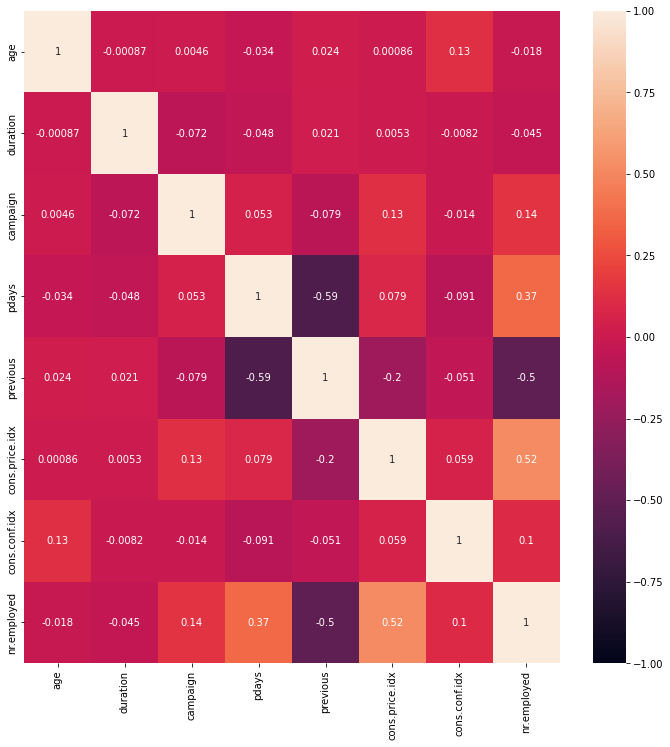

In [342]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),annot=True,vmin=-1,vmax=1)
plt.show()

Text(0.5, 1.0, 'Campaign')

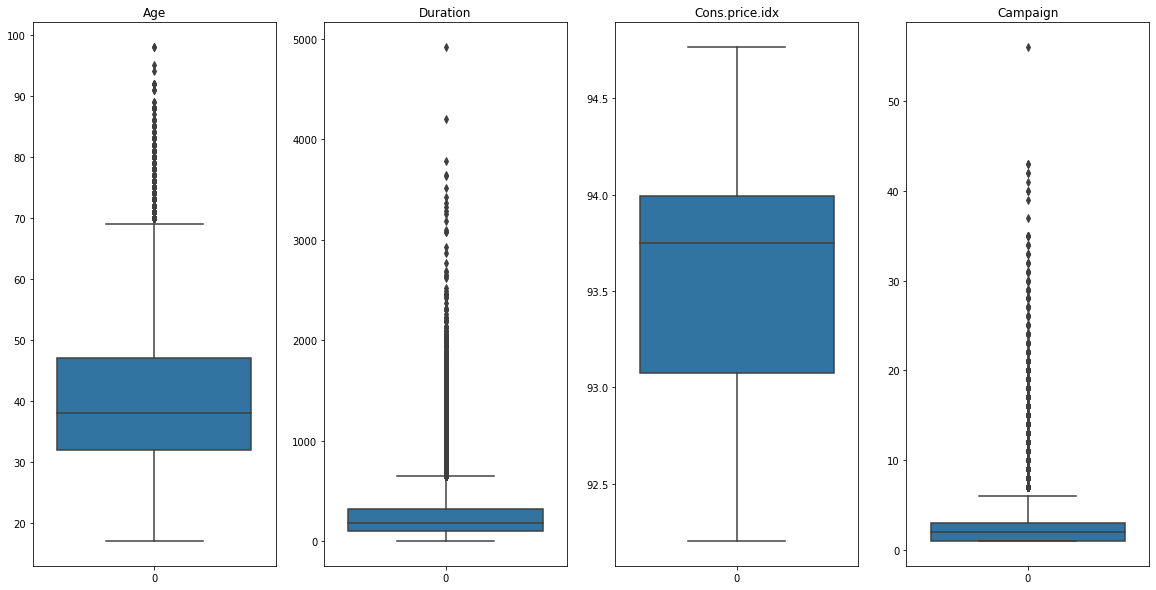

In [343]:
fig, axes = plt.subplots(1,4,figsize=(20, 10))
sns.boxplot(data=X['age'],ax=axes[0])
axes[0].set_title('Age')

sns.boxplot(data=X['duration'],ax=axes[1])
axes[1].set_title('Duration')

sns.boxplot(data=X['cons.price.idx'],ax=axes[2])
axes[2].set_title('Cons.price.idx')

sns.boxplot(data=X['campaign'],ax=axes[3])
axes[3].set_title('Campaign')


In [344]:

stats = numeric_features.describe()
for feature in numeric_features.columns:
    IQR = stats[feature]['75%'] - stats[feature]['25%']
    superior = stats[feature]['75%'] + IQR*1.5
    inferior = stats[feature]['25%'] - IQR*1.5

    df[feature] = df[feature].apply(lambda x: x if (superior >= x and inferior <= x) else None)



In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             40719 non-null  float64
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        38225 non-null  float64
 11  campaign        38782 non-null  float64
 12  pdays           39673 non-null  float64
 13  previous        35563 non-null  float64
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   40741 non-null 

In [346]:
#dropeo todos los outliers
df = df.dropna()

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30360 entries, 0 to 41186
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30360 non-null  float64
 1   job             30360 non-null  object 
 2   marital         30360 non-null  object 
 3   education       30360 non-null  object 
 4   default         30360 non-null  object 
 5   housing         30360 non-null  object 
 6   loan            30360 non-null  object 
 7   contact         30360 non-null  object 
 8   month           30360 non-null  object 
 9   day_of_week     30360 non-null  object 
 10  duration        30360 non-null  float64
 11  campaign        30360 non-null  float64
 12  pdays           30360 non-null  float64
 13  previous        30360 non-null  float64
 14  poutcome        30360 non-null  object 
 15  emp.var.rate    30360 non-null  float64
 16  cons.price.idx  30360 non-null  float64
 17  cons.conf.idx   30360 non-null 

In [348]:
df['age'].describe()

count    30360.000000
mean        39.671080
std          9.480333
min         18.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         69.000000
Name: age, dtype: float64

In [349]:
# La feature tiene un rango entre 18-98
df["age"].describe()

count    30360.000000
mean        39.671080
std          9.480333
min         18.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         69.000000
Name: age, dtype: float64

In [350]:
age_groups = pd.cut(df['age'],bins=[10,20,30,40,50,60,70],labels=['10-19','20-29','30-39','40-49','50-59','60-69'])

df.insert(1,'age_group',age_groups)

In [351]:
df = df.drop(columns=['age'],axis=1)

In [352]:
levels =['basic.9y','basic.6y','basic.4y']
for i in levels:
    df.loc[df['education'] == i, 'education'] = "middle.school"

In [353]:
df['education'].unique()

array(['middle.school', 'high.school', 'professional.course',
       'university.degree', 'illiterate'], dtype=object)

In [354]:
# drop de pdays

df.drop(columns = ['pdays'], axis=1, inplace=True)

In [355]:
# Eliminamos duplicados

df = df.drop_duplicates()

In [356]:
# Convertrir columna 'y' a una variable binaria

df['y'].replace({"yes":1,"no":0},inplace=True)

In [358]:
# Encodear features categoricas ordinarias (age, education)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['age_group'] = encoder.fit_transform(df['age_group'])
df['education'] = encoder.fit_transform(df['education'])

In [359]:
# Encodear features categoricas no ordinarias (job, marital, default, housing, loan, contact, poutcome)

df = pd.get_dummies(df, columns = ['job', 'marital', 'default','housing', 'loan', 'contact', 'poutcome'])


In [360]:
months={'may':5,'jul':7,'aug':8,'jun':6,'nov':11,'apr':4,'oct':10,'sep':9,'mar':3,'dec':12}
df['month']= df['month'].map(months) 

In [361]:
days={'thu':5,'mon':2,'wed':4,'tue':3,'fri':6}
df['day_of_week']= df['day_of_week'].map(days) 

In [362]:
df.sample(10)

,age_group,education,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_nonexistent
33175,3,2,5,3,58.0,1.0,0.0,-1.8,92.893,-46.2,...,0,1,0,1,0,1,0,1,0,1
5532,4,0,5,2,437.0,1.0,0.0,1.1,93.994,-36.4,...,0,1,0,0,1,0,1,0,1,1
10409,4,2,6,2,155.0,4.0,0.0,1.4,94.465,-41.8,...,0,1,0,1,0,1,0,0,1,1
28775,1,4,4,5,100.0,1.0,0.0,-1.8,93.075,-47.1,...,1,1,0,0,1,1,0,0,1,1
23851,3,0,8,6,156.0,1.0,0.0,1.4,93.444,-36.1,...,0,1,0,0,1,1,0,1,0,1
34243,1,0,5,5,36.0,6.0,0.0,-1.8,92.893,-46.2,...,1,1,0,0,1,1,0,0,1,1
2579,4,2,5,3,210.0,3.0,0.0,1.1,93.994,-36.4,...,0,1,0,0,1,1,0,0,1,1
10358,2,2,6,2,39.0,1.0,0.0,1.4,94.465,-41.8,...,0,1,0,0,1,1,0,0,1,1
2245,2,0,5,2,81.0,4.0,0.0,1.1,93.994,-36.4,...,0,1,0,0,1,1,0,0,1,1
7338,3,3,5,6,149.0,1.0,0.0,1.1,93.994,-36.4,...,0,1,0,0,1,1,0,0,1,1


In [ ]:
#Pasamos los type objeto a categorical
object_columns = list(df.dtypes[df.dtypes == "object"].index)
for cols in object_columns:
    df[cols] = pd.Categorical(df[cols])